In [1]:
# Shiman Ding, shiman@berkeley.edu
# IEOR, 24104985
# 09/10/2016, AY250-HW2
# Data Visualization

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

0) Critique the most important figure from a seminal paper in your field. Provide the original figure/caption. In your own words, what story is this figure trying to convey? What does it do well? What could have been done better? What elements didn't need to be present to still convey the same story?

<img src="hw_2_data/critic.png">
<br/>

The figure is trying to show how min cuts can be achieved via clustering. The example is simple enough with insights. But G1 and G2 are not clearly defined in the graph. They may also use dashed line for cuts and clusters. They may also use different color for cuts and clusters. If flow is included in the graph, that would be better.

2) Reproduce in matplotlib the provided plot stocks.png  Use the provided datafiles ny_temps.txt, yahoo_data.txt, and google_data.txt. Provide your new plot and the Python code.

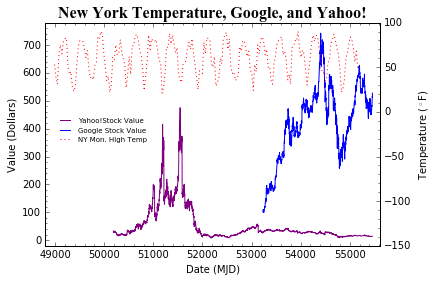

In [5]:
ny_temps = np.loadtxt("hw_2_data/ny_temps.txt", skiprows=1)
yahoo_data = np.loadtxt("hw_2_data/yahoo_data.txt", skiprows=1)
google_data = np.loadtxt("hw_2_data/google_data.txt", skiprows=1)
fig = plt.figure()
ax1 = fig.add_subplot(111)

yahoo = ax1.plot(yahoo_data[:,0], yahoo_data[:,1], color = 'purple', 
         linestyle = '-', label = "Yahoo!Stock Value")
google = ax1.plot(google_data[:,0], google_data[:,1], color = 'blue', 
         linestyle = '-', label = "Google Stock Value")

# add secondary y axis
ax2 = ax1.twinx()
temps = ax2.plot(ny_temps[:,0], ny_temps[:,1], color = 'red', 
         linestyle = ':', label = "NY Mon. High Temp")

# add legend together
data = yahoo + google + temps
labs = [l.get_label() for l in data]
ax1.legend(data, labs, loc=(0.03,.45), prop={'size':7}, frameon=False)

ax1.set_title("New York Temperature, Google, and Yahoo!", 
              size = 16, family='Times New Roman', fontweight="bold")
ax1.set_xlabel("Date (MJD)")
ax1.set_ylabel("Value (Dollars)")
ax2.set_ylabel("Temperature ($^\circ$F)")
ax1.set_xlim(48800, 55620)
ax1.set_ylim(-20, 780)
ax1.minorticks_on()
ax2.set_ylim(-150,100)
ax2.minorticks_on()